### 60192193 박세진 Homework 1

먼저 선형회귀 모델을 만들기 위한 라이브러리들을 모두 import 해주겠습니다.

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import  linear_model

초기설정을 해주겠습니다.

In [50]:
# 동일한 실행 결과를 얻기 위한 랜덤 시드 설정
np.random.seed(42)

#그래프 출력 설정
plt.rc('font', size=12)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=12)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

먼저 GDP 데이터를 가져오도록 하겠습니다. <br>
2015년 한국의 1인당 GDP 값이 결측치이기 때문에 이 데이터프레임을 다른 변수에 복사한 뒤<br>
2010~2014년 한국의 1인당 GDP 평균을 구할 때 재사용하도록 하겠습니다.


In [51]:
gdp_per_capita_url = "https://drive.google.com/file/d/1-IBuM27Yjveq7TcdgxUE3jKYA_5E5BND/view?usp=sharing"
gdp_per_capita_filepath = "https://drive.google.com/uc?id=" + gdp_per_capita_url.split('/')[-2]
gdp_per_capita = pd.read_csv(gdp_per_capita_filepath,
                             thousands=',',
                             encoding='latin1',
                             na_values="n/a")
copy_gdp_per_capita = gdp_per_capita
gdp_per_capita

,Entity,Code,Year,"GDP per capita, PPP (constant 2017 international $)"
0,Afghanistan,AFG,2002,1189.784668
1,Afghanistan,AFG,2003,1235.810063
2,Afghanistan,AFG,2004,1200.278013
3,Afghanistan,AFG,2005,1286.793659
4,Afghanistan,AFG,2006,1315.789117
...,...,...,...,...
7104,Zimbabwe,ZWE,2016,3173.610829
7105,Zimbabwe,ZWE,2017,3274.611198
7106,Zimbabwe,ZWE,2018,3341.665418
7107,Zimbabwe,ZWE,2019,3027.656038


국가별 1인당 GDP 데이터에서 2015년 데이터만 추려내도록 하겠습니다.

In [52]:
mask_gdp_2015 = gdp_per_capita["Year"] == 2015
gdp_per_capita = gdp_per_capita[mask_gdp_2015]
gdp_per_capita

,Entity,Code,Year,"GDP per capita, PPP (constant 2017 international $)"
13,Afghanistan,AFG,2015,2068.265904
44,Africa Eastern and Southern,NaN,2015,3549.480563
75,Africa Western and Central,NaN,2015,4202.057923
106,Albania,ALB,2015,11878.488093
137,Algeria,DZA,2015,11696.965229
...,...,...,...,...
6979,Vanuatu,VUT,2015,2915.700460
7010,Vietnam,VNM,2015,6438.259854
7041,World,OWID_WRL,2015,15509.996467
7072,Zambia,ZMB,2015,3443.553254


국가별 1인당 GDP 데이터 내용중 "Code"와 "Year" 열은 필요하지 않기 때문에 삭제하겠습니다

In [53]:
gdp_per_capita = gdp_per_capita.drop(["Code", "Year"], axis=1)
gdp_per_capita

,Entity,"GDP per capita, PPP (constant 2017 international $)"
13,Afghanistan,2068.265904
44,Africa Eastern and Southern,3549.480563
75,Africa Western and Central,4202.057923
106,Albania,11878.488093
137,Algeria,11696.965229
...,...,...
6979,Vanuatu,2915.700460
7010,Vietnam,6438.259854
7041,World,15509.996467
7072,Zambia,3443.553254


1인당 GDP 데이터에서는 국가명 South Korea가 사용되며, 삶의 만족도 데이터에서는 국가명으로 Korea가 사용된다. <br>
동일한 국가명으로 맞춰주기 위해 1인당 GDP 데이터의 South Korea를 Korea로 변경해주겠습니다.

In [54]:
gdp_per_capita.loc[gdp_per_capita["Entity"] == "South Korea", "Entity"] = "Korea"
gdp_per_capita.loc[gdp_per_capita["Entity"] == "Korea"]

,Entity,"GDP per capita, PPP (constant 2017 international $)"
6083,Korea,NaN


1인당 GDP 데이터 테이블 각 열(column)의 인덱스를 다음과 같이 변경해주겠습니다.

In [55]:
gdp_per_capita.columns = ["Country", "GDP per capita (USD)"]
gdp_per_capita

,Country,GDP per capita (USD)
13,Afghanistan,2068.265904
44,Africa Eastern and Southern,3549.480563
75,Africa Western and Central,4202.057923
106,Albania,11878.488093
137,Algeria,11696.965229
...,...,...
6979,Vanuatu,2915.700460
7010,Vietnam,6438.259854
7041,World,15509.996467
7072,Zambia,3443.553254


2015년의 Korea 1인당 GDP 지수가 결측값이기 때문에 <br>
2010년~2014년 South Korea의 1인당 GDP 값의 median으로 채우겠습니다. <br>
아까 복사해 놓은 copy 데이터들을 활용하겠습니다.

In [56]:
korea_mask = copy_gdp_per_capita["Entity"] == "South Korea" #한국 데이터들만 가져오기
copy_gdp_per_capita = copy_gdp_per_capita[korea_mask]

year_mask = (copy_gdp_per_capita["Year"] >= 2010) & (copy_gdp_per_capita["Year"] <= 2014) #2010 ~ 2014년 데아터만 가져오기
copy_gdp_per_capita = copy_gdp_per_capita[year_mask]

gdps = copy_gdp_per_capita["GDP per capita, PPP (constant 2017 international $)"].values # GDP Value 들만 추출 후 numpy의 median 함수로 중간값 구하기
median = np.median(gdps)
median

36049.1934873539

2010~2014년의 한국 1인당 GDP를 구했으니 이를 원본 데이터에 넣어주겠습니다.

In [57]:
gdp_per_capita.loc[gdp_per_capita["Country"] == "Korea", "GDP per capita (USD)"] = median # 2015년 한국 1인당 GDP 열에 median 데이터 입력
gdp_per_capita.loc[gdp_per_capita["Country"] == "Korea"]

,Country,GDP per capita (USD)
6083,Korea,36049.193487


데이터 입력이 완료되었으니 국가명을 행 인덱스로 지정하겠습니다. 총 240개 국가의 1인당 GDP정보를 담고있습니다. <br>
inplace=True를 사용해서 set_index 실행 결과로 gdp_per_capita 데이터프레임 자체가 업데이트 되도록 하겠습니다.

In [58]:
gdp_per_capita.set_index("Country", inplace=True)
gdp_per_capita

,GDP per capita (USD)
Country,
Afghanistan,2068.265904
Africa Eastern and Southern,3549.480563
Africa Western and Central,4202.057923
Albania,11878.488093
Algeria,11696.965229
...,...
Vanuatu,2915.700460
Vietnam,6438.259854
World,15509.996467


다음으로 OECD 국가별 삶의 만족도 데이터를 가져오도록 하겠습니다.

In [59]:
oecd_bli_2015_url = "https://drive.google.com/file/d/1-Hr5ptxnhwbC5iLSqwK3eV3ZiHUIRHPy/view?usp=sharing" # oecd_bli_2015.csv 공유링크
oecd_bli_2015_filepath = "https://drive.google.com/uc?id=" + oecd_bli_2015_url.split('/')[-2]
oecd_bli_2015 = pd.read_csv(oecd_bli_2015_filepath, thousands=',')
oecd_bli_2015

,LOCATION,Country,INDICATOR,Indicator,MEASURE,Measure,INEQUALITY,Inequality,Unit Code,Unit,PowerCode Code,PowerCode,Reference Period Code,Reference Period,Value,Flag Codes,Flags
0,AUS,Australia,HO_BASE,Dwellings without basic facilities,L,Value,TOT,Total,PC,Percentage,0,units,NaN,NaN,1.10,E,Estimated value
1,AUT,Austria,HO_BASE,Dwellings without basic facilities,L,Value,TOT,Total,PC,Percentage,0,units,NaN,NaN,1.00,NaN,NaN
2,BEL,Belgium,HO_BASE,Dwellings without basic facilities,L,Value,TOT,Total,PC,Percentage,0,units,NaN,NaN,2.00,NaN,NaN
3,CAN,Canada,HO_BASE,Dwellings without basic facilities,L,Value,TOT,Total,PC,Percentage,0,units,NaN,NaN,0.20,NaN,NaN
4,CZE,Czech Republic,HO_BASE,Dwellings without basic facilities,L,Value,TOT,Total,PC,Percentage,0,units,NaN,NaN,0.90,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3287,EST,Estonia,WL_TNOW,Time devoted to leisure and personal care,L,Value,WMN,Women,HOUR,Hours,0,units,NaN,NaN,14.43,NaN,NaN
3288,ISR,Israel,WL_TNOW,Time devoted to leisure and personal care,L,Value,WMN,Women,HOUR,Hours,0,units,NaN,NaN,14.24,E,Estimated value
3289,RUS,Russia,WL_TNOW,Time devoted to leisure and personal care,L,Value,WMN,Women,HOUR,Hours,0,units,NaN,NaN,14.75,E,Estimated value
3290,SVN,Slovenia,WL_TNOW,Time devoted to leisure and personal care,L,Value,WMN,Women,HOUR,Hours,0,units,NaN,NaN,14.12,NaN,NaN


전체 인구를 대상으로하는 TOT 기준에 포함된 데이터만 추출하겠습니다.

In [60]:
oecd_bli_2015 = oecd_bli_2015[oecd_bli_2015["INEQUALITY"] == "TOT"]
oecd_bli_2015

,LOCATION,Country,INDICATOR,Indicator,MEASURE,Measure,INEQUALITY,Inequality,Unit Code,Unit,PowerCode Code,PowerCode,Reference Period Code,Reference Period,Value,Flag Codes,Flags
0,AUS,Australia,HO_BASE,Dwellings without basic facilities,L,Value,TOT,Total,PC,Percentage,0,units,NaN,NaN,1.10,E,Estimated value
1,AUT,Austria,HO_BASE,Dwellings without basic facilities,L,Value,TOT,Total,PC,Percentage,0,units,NaN,NaN,1.00,NaN,NaN
2,BEL,Belgium,HO_BASE,Dwellings without basic facilities,L,Value,TOT,Total,PC,Percentage,0,units,NaN,NaN,2.00,NaN,NaN
3,CAN,Canada,HO_BASE,Dwellings without basic facilities,L,Value,TOT,Total,PC,Percentage,0,units,NaN,NaN,0.20,NaN,NaN
4,CZE,Czech Republic,HO_BASE,Dwellings without basic facilities,L,Value,TOT,Total,PC,Percentage,0,units,NaN,NaN,0.90,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3213,EST,Estonia,WL_TNOW,Time devoted to leisure and personal care,L,Value,TOT,Total,HOUR,Hours,0,units,NaN,NaN,14.90,NaN,NaN
3214,ISR,Israel,WL_TNOW,Time devoted to leisure and personal care,L,Value,TOT,Total,HOUR,Hours,0,units,NaN,NaN,14.48,E,Estimated value
3215,RUS,Russia,WL_TNOW,Time devoted to leisure and personal care,L,Value,TOT,Total,HOUR,Hours,0,units,NaN,NaN,14.97,E,Estimated value
3216,SVN,Slovenia,WL_TNOW,Time devoted to leisure and personal care,L,Value,TOT,Total,HOUR,Hours,0,units,NaN,NaN,14.62,NaN,NaN


데이터프레임 객체의 pivot() 메서드를 이용하여 'Indicator'의 항목에 대한 각 국가별 수치만을 추출하기 위해 국가명 <br>
('Country' 열의 항목)을 행의 인덱스 이름으로, 'Indicator'의 항목을 열의 인덱스 이름으로 사용하면서 해당 행과 열의<br>
항목에는 'Value'열에 포합된 값을 사용하는 데이터프레임을 생성하겠습니다.

In [61]:
oecd_bli_2015 = oecd_bli_2015.pivot(index="Country", columns="Indicator", values="Value")
oecd_bli_2015

Indicator,Air pollution,Assault rate,Consultation on rule-making,Dwellings without basic facilities,Educational attainment,Employees working very long hours,Employment rate,Homicide rate,Household net adjusted disposable income,Household net financial wealth,...,Long-term unemployment rate,Personal earnings,Quality of support network,Rooms per person,Self-reported health,Student skills,Time devoted to leisure and personal care,Voter turnout,Water quality,Years in education
Country,,,,,,,,,,,,,,,,,,,,,
Australia,13.0,2.1,10.5,1.1,76.0,14.02,72.0,0.8,31588.0,47657.0,...,1.08,50449.0,92.0,2.3,85.0,512.0,14.41,93.0,91.0,19.4
Austria,27.0,3.4,7.1,1.0,83.0,7.61,72.0,0.4,31173.0,49887.0,...,1.19,45199.0,89.0,1.6,69.0,500.0,14.46,75.0,94.0,17.0
Belgium,21.0,6.6,4.5,2.0,72.0,4.57,62.0,1.1,28307.0,83876.0,...,3.88,48082.0,94.0,2.2,74.0,509.0,15.71,89.0,87.0,18.9
Brazil,18.0,7.9,4.0,6.7,45.0,10.41,67.0,25.5,11664.0,6844.0,...,1.97,17177.0,90.0,1.6,69.0,402.0,14.97,79.0,72.0,16.3
Canada,15.0,1.3,10.5,0.2,89.0,3.94,72.0,1.5,29365.0,67913.0,...,0.90,46911.0,92.0,2.5,89.0,522.0,14.25,61.0,91.0,17.2
Chile,46.0,6.9,2.0,9.4,57.0,15.42,62.0,4.4,14533.0,17733.0,...,1.59,22101.0,86.0,1.2,59.0,436.0,14.41,49.0,73.0,16.5
Czech Republic,16.0,2.8,6.8,0.9,92.0,6.98,68.0,0.8,18404.0,17299.0,...,3.12,20338.0,85.0,1.4,60.0,500.0,14.98,59.0,85.0,18.1
Denmark,15.0,3.9,7.0,0.9,78.0,2.03,73.0,0.3,26491.0,44488.0,...,1.78,48347.0,95.0,1.9,72.0,498.0,16.06,88.0,94.0,19.4
Estonia,9.0,5.5,3.3,8.1,90.0,3.30,68.0,4.8,15167.0,7680.0,...,3.82,18944.0,89.0,1.5,54.0,526.0,14.90,64.0,79.0,17.5


1인당 GDP 데이터는 OECD 회원국 이외의 국가 데이터도 포함되어 있다. OECD 회원국으로 제한해서 1인당 GDP와 삶의<br>
만족도 사이의 관계를 파악하기 위해 앞서 구한 두 개의 데이터 프레임을 하나로 병합한다.

In [62]:
oecd_country_stats = pd.merge(left=gdp_per_capita['GDP per capita (USD)'],
                              right=oecd_bli_2015['Life satisfaction'],
                              left_index=True, right_index=True)
oecd_country_stats

,GDP per capita (USD),Life satisfaction
Country,,
Australia,47636.319642,7.3
Austria,52798.099461,6.9
Belgium,49455.441337,6.9
Brazil,15064.176069,7.0
Canada,47522.140667,7.3
Chile,24440.415264,6.7
Denmark,52892.646029,7.5
Estonia,31146.754522,5.6
Finland,45072.590215,7.4


1인당 GDP와 삶의 만족도 사이의 선형 관계를 눈으로 확인하기 위해 국가를 1인당 GDP 기준 오름차순으로 정렬시킨다.

In [63]:
oecd_country_stats.sort_values(by="GDP per capita (USD)", inplace=True)
oecd_country_stats.shape

(34, 2)

Brazil, Mexico, Chile, Norway, Switzerland, Ireland, Luxembourg 를 제외시키고 훈련을 시키겠습니다.

In [64]:
omitted_indices = [0, 1, 2, 30, 31, 32, 33]
kept_indices = list(set(range(34)) - set(omitted_indices))
kept_indices

[3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29]

In [65]:
# 제외된 9개 국가의 1인당 GDP와 삶의 만족도 데이터
missing_data = oecd_country_stats.iloc[omitted_indices]

# 9개 국가를 제외한 국가들의 1인당 GDP와 삶의 만족도 데이터
sample_data = oecd_country_stats.iloc[kept_indices]
sample_data

,GDP per capita (USD),Life satisfaction
Country,,
Russia,25488.096120,6.0
Turkey,25958.640762,5.6
Hungary,27499.324466,4.9
Poland,27797.058423,5.8
Greece,28248.125956,4.8
Portugal,31118.790670,5.1
Estonia,31146.754522,5.6
Slovenia,33805.030045,5.7
Korea,36049.193487,5.8


1인당 GDP와 삶의 만족도 사이에 다음 선형 관계가 성립합니다.
$$
\textit{Life Satisfaction} = \theta_0 + \theta_1 \cdot \textit{GDP per Capita}
$$
scikit-learn 라이브러리를 이용해 최적의 절편과 기울기를 계산하겠습니다.

In [66]:
lin1 = linear_model.LinearRegression() #아직 훈련이 되지 않은 모델

훈련 셋을 지정하겠습니다. <br>
입력 데이터: 1인당 GDP <br>
출력 데이터: 삶의 만족도 <br>
사이킷런의 선형회귀 모델이 어레이 형식의 입력 데이터 셋과 타깃 데이터 셋을 요구하므로 <br>
넘파이의 c_함수를 활용해서 차원을 늘려주겠습니다.

In [67]:
Xsample = np.c_[sample_data["GDP per capita (USD)"]]
Ysample = np.c_[sample_data["Life satisfaction"]]

선형 모델의 fit() 메서드를 입력 데이터 셋과 타깃 데이터 셋을 인자로 사용해서 호출해 최적의 파라미터를 찾겠습니다.

In [68]:
lin1.fit(Xsample, Ysample)

LinearRegression()

훈련된 모델이 알아낸 최적 선형 모델의 절편과 기울기를 두 속성에 저장하겠습니다.

In [69]:
t0, t1 = lin1.intercept_[0], lin1.coef_[0][0]
print(f"절편:\t {t0}")
print(f"기울기:\t {t1}")

절편:	 3.4940168404150898
기울기:	 7.269184070964762e-05


구해진 기울기와 절편을 이용하여 산점도와 함께 직선을 그리겠습니다.

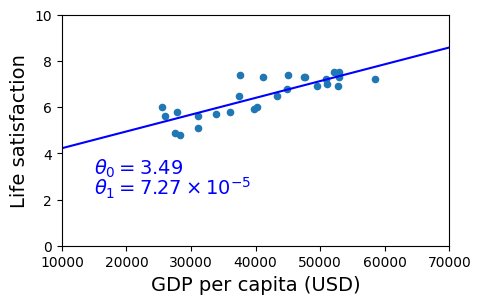

In [70]:
# 산점도
sample_data.plot(kind='scatter', x="GDP per capita (USD)", y="Life satisfaction", figsize=(5,3))
plt.xlabel("GDP per capita (USD)")
plt.axis([10000, 70000, 0, 10])

# 직선 그리기
X=np.linspace(0, 70000, 1000)
plt.plot(X, t0 + t1*X, "b")

#직선의 절편과 기울기 정보 명시
plt.text(15000, 3.1, r"$\theta_0 = 3.49$", fontsize=14, color="b")
plt.text(15000, 2.2, r"$\theta_1 = 7.27 \times 10^{-5}$", fontsize=14, color="b")

plt.show()

한 국가의 1인당 GDP가 알려졌을 때 훈련된 모델에 포함된 θ0와 θ1을 이용하여 해당 국가의 삶의 만족도를 예측하겠습니다. <br>
Cyprus의 2015년 1인당 GDP 값을 입력으로 삶의 만족도 지수를 예측하겠습니다.

In [71]:
cyprus_gdp_per_capita = gdp_per_capita.loc["Cyprus"]["GDP per capita (USD)"]
cyprus_gdp_per_capita

34472.2985065115

훈련된 모델의 predict() 메서드가 식을 이용하여 삶의 만족도를 계산합니다.

In [72]:
cyprus_predicted_life_satisfaction = lin1.predict([[cyprus_gdp_per_capita]])[0, 0]
cyprus_predicted_life_satisfaction

5.999871672345847

실제 삶의 만족도 지수는 5.63이라고 합니다. 5.99인 예측값과 비슷하다는 것을 알 수 있었습니다.